In [0]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

from tqdm import tqdm
import sys, random, glob
from itertools import chain
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from inception_score import get_inception_score
from fid import get_fid_score

In [0]:
SEED = 1234
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
# batches of 64 images of size 32x32x3

BATCH_SIZE = 64
NUM_WORKERS = 4
LATENT_DIM = 100
IN_CHANNELS = 3
OUT_CHANNELS = 3

IMG_SIZE = 32

transform = transforms.Compose([transforms.Resize(IMG_SIZE),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.CIFAR10('datasets/CIFAR10',
                               transform=transform)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=NUM_WORKERS)

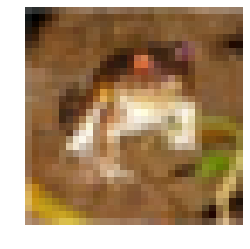

In [0]:
img, _ = dataset[0] # image data should either be floats in [0, 1] or integers in [0, 255]
assert img.shape == (IN_CHANNELS, IMG_SIZE, IMG_SIZE)
assert isinstance(img, torch.Tensor)

img = (img.permute(1, 2, 0) + 1)/2 # HWC and denorm

ax = plt.gca()
ax.imshow(img)
ax.axis('off')
plt.show()

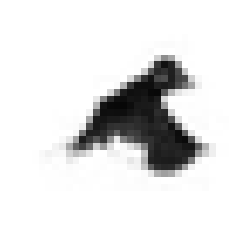

In [0]:
imgs, _ = next(iter(dataloader))

assert imgs.shape == (BATCH_SIZE, IN_CHANNELS, IMG_SIZE, IMG_SIZE)
assert isinstance(imgs, torch.Tensor)

img = (imgs[0].permute(1, 2, 0) + 1)/2 # HWC and denorm

ax = plt.gca()
ax.imshow(img)
ax.axis('off')
plt.show()

In [0]:
# W --> (W - 1)S + K - 2P
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_ch):
        super().__init__()

        self.model = nn.Sequential(
            # input is z: 100 x (1 x 1)
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # state size: 512 x (4 x 4)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # state size: 256 x (8 x 8)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # state size: 128 x (16 x 16)
            nn.ConvTranspose2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # state size: 64 x (16 x 16)
            nn.ConvTranspose2d(64, output_ch, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: och x (32 x 32)
        )
        # input order: NCHW (batch, channels, height, width)
        
    def forward(self, z):
        Gz = self.model(z)
        return Gz

In [0]:
# W --> [(W - K + 2P)/S + 1]
class Encoder(nn.Module):
    def __init__(self, input_ch, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            # input size: ich x (32 x 32)
            nn.Conv2d(input_ch, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 64 x (16 x 16)
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 128 x (16 x 16)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 256 x (8 x 8)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 512 x (4 x 4)
            nn.Conv2d(512, latent_dim, 4, 1, 0, bias=False), # changed (512, 1, ..) to (512, 100, ..), removed sigmoid, removed flattening from forward
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [0]:
# custom weights initialization for G, D
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

        
netAE = nn.Sequential(Encoder(IN_CHANNELS, LATENT_DIM),
                      Decoder(LATENT_DIM, OUT_CHANNELS)).to(device)
netAE.apply(init_weights)
netAE

Sequential(
  (0): Encoder(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace)
      (11): Conv2d(512, 100, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
  )
  (1): Decoder(
    (mod

In [0]:
opt = optim.Adam(netAE.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = torch.nn.MSELoss()

def denorm(x):
    out = (x + 1)/2
    return out.clamp(0, 1)

In [0]:
SAMPLES = 6
imgloader = torch.utils.data.DataLoader(dataset, batch_size=SAMPLES, shuffle=True)
imgs, _ = next(iter(imgloader))
imgs = imgs.to(device)

In [0]:
#=========================AUTOENCODER=========================#
EPOCHS = 30
SAVE_EVERY = 2
losses = []

for e in range(1, EPOCHS + 1):
    losses.append(0)
    
    #--------------------Training--------------------#
    for x, _ in dataloader:
        x = x.to(device)
        
        fx = netAE(x)
        loss = criterion(fx, x); losses[-1] += loss.item()
        opt.zero_grad()    
        loss.backward()
        opt.step()
    
    #---------------------Logging---------------------#
    losses[-1] /= len(dataloader)
    
    print(f"Epoch: {e:02}/{EPOCHS} "
          f"| Loss: {losses[-1]:.5f}", file=sys.stderr)
    
    #-------------------Save & Plot-------------------#
    if e % SAVE_EVERY == 0:
        filepath = f'models/netAE-{e:02}-{losses[-1]:.4f}.pt'
        torch.save(netAE.state_dict(), filepath)
        
        with torch.no_grad():
            gen_imgs = netAE(imgs)

        fig, ax = plt.subplots(figsize=(22, 20), nrows=1, ncols=2*SAMPLES)
        for i in range(2*SAMPLES):
            img = gen_imgs[(i - 1) // 2] if i%2 else imgs[i // 2]
            img = denorm(img.data.cpu().permute(1, 2, 0))
            ax[i].imshow(img)
            ax[i].axis('off')
        plt.show()

# training time: 1.2 min/epoch, 36 mins

In [0]:
ls = glob.glob('models/netAE-30-*')
filename = ls[-1]; print(filename)

netAE.load_state_dict(torch.load(filename, map_location=device))

next(netAE.parameters()).device

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

    
layersG = list(netAE[1].model.children())
layersD = list(netAE[0].model.children())

netG = nn.Sequential(*layersG).to(device)
netD = nn.Sequential(*layersD[:-1],
                    nn.Conv2d(512, 1, 4, 1, 0, bias=False),
                    nn.Sigmoid(),
                    Flatten()).to(device)

In [0]:
netG

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace)
  (9): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [0]:
netD

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace)
  (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
  (13): Flatten()
)

In [0]:
for i, layer in enumerate(netG.children()):
    if i in (0, 3): # reusing 0th and 3rd layer (2 layers from AE decoder)
        continue
    else:
        layer.apply(init_weights)

for i, layer in enumerate(netD.children()):
    if i in (8,): # reusing 8th layer (1 layer from AE encoder)
        continue
    else:
        layer.apply(init_weights)
        

In [0]:
optG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = torch.nn.BCELoss()

Epoch: 01/55 | Gen. Loss: 4.17859 | Disc. Loss: 0.69949 | Incep. Score: 2.35072


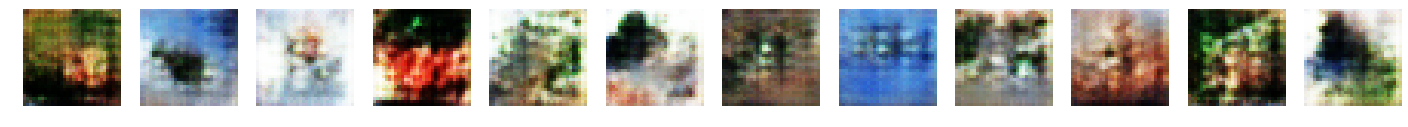

Epoch: 02/55 | Gen. Loss: 3.51711 | Disc. Loss: 0.68793 | Incep. Score: 3.62322


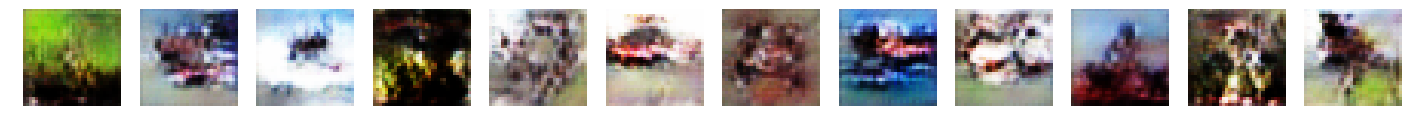

Epoch: 03/55 | Gen. Loss: 2.81603 | Disc. Loss: 0.79406 | Incep. Score: 3.90530


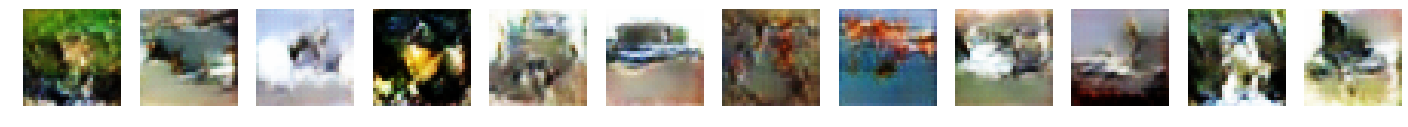

Epoch: 04/55 | Gen. Loss: 2.73113 | Disc. Loss: 0.74662 | Incep. Score: 4.39489


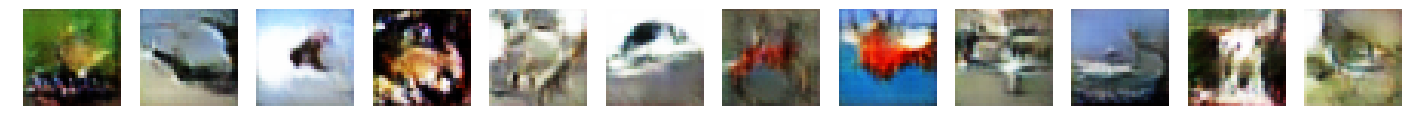

Epoch: 05/55 | Gen. Loss: 2.53689 | Disc. Loss: 0.80433 | Incep. Score: 4.75204


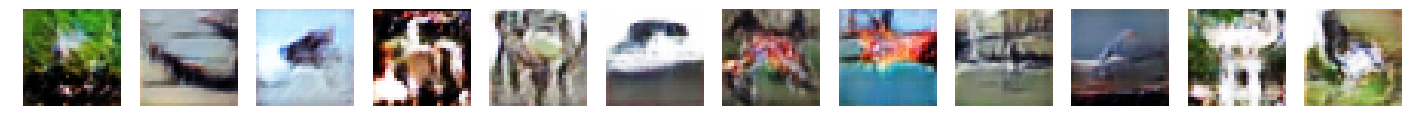

Epoch: 06/55 | Gen. Loss: 2.40630 | Disc. Loss: 0.85285 | Incep. Score: 5.18245


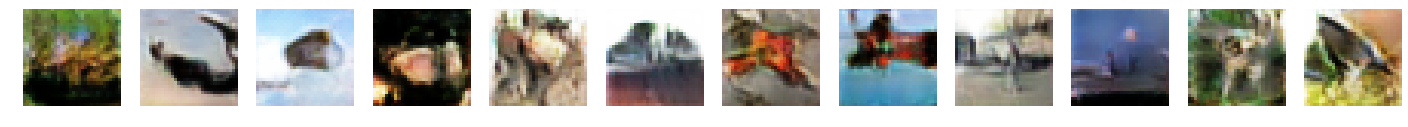

Epoch: 07/55 | Gen. Loss: 2.30993 | Disc. Loss: 0.87691 | Incep. Score: 5.54249


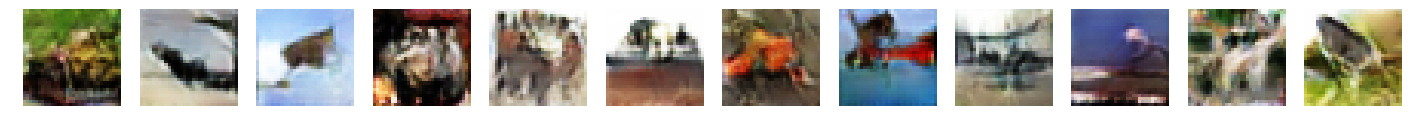

Epoch: 08/55 | Gen. Loss: 2.27193 | Disc. Loss: 0.84918 | Incep. Score: 5.57643


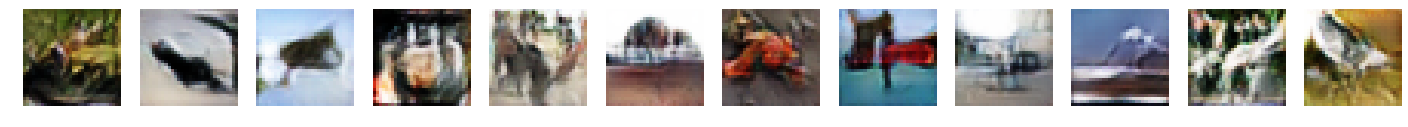

Epoch: 09/55 | Gen. Loss: 2.31061 | Disc. Loss: 0.84618 | Incep. Score: 5.95403


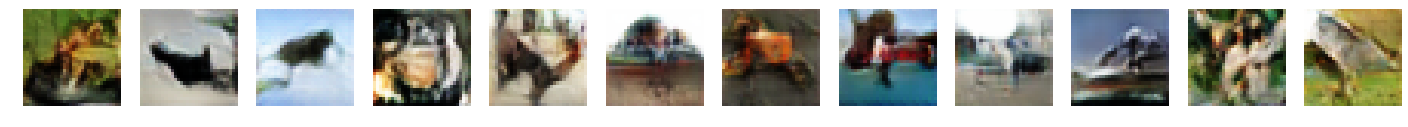

Epoch: 10/55 | Gen. Loss: 2.34265 | Disc. Loss: 0.82713 | Incep. Score: 6.39531


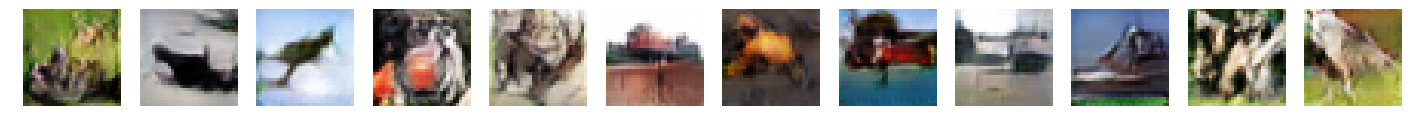

Epoch: 11/55 | Gen. Loss: 2.43371 | Disc. Loss: 0.78083 | Incep. Score: 6.13429
Epoch: 12/55 | Gen. Loss: 2.52177 | Disc. Loss: 0.72821 | Incep. Score: 6.11680
Epoch: 13/55 | Gen. Loss: 2.58343 | Disc. Loss: 0.72079 | Incep. Score: 6.22056
Epoch: 14/55 | Gen. Loss: 2.62038 | Disc. Loss: 0.69978 | Incep. Score: 6.32135
Epoch: 15/55 | Gen. Loss: 2.69525 | Disc. Loss: 0.67400 | Incep. Score: 6.34442
Epoch: 16/55 | Gen. Loss: 2.82652 | Disc. Loss: 0.62348 | Incep. Score: 6.26926
Epoch: 17/55 | Gen. Loss: 2.86845 | Disc. Loss: 0.60966 | Incep. Score: 6.28524
Epoch: 18/55 | Gen. Loss: 2.95665 | Disc. Loss: 0.57096 | Incep. Score: 6.61401


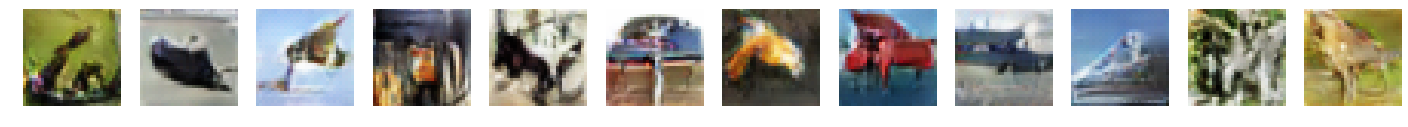

Epoch: 19/55 | Gen. Loss: 3.09210 | Disc. Loss: 0.61417 | Incep. Score: 6.35606
Epoch: 20/55 | Gen. Loss: 3.06900 | Disc. Loss: 0.49990 | Incep. Score: 6.53485
Epoch: 21/55 | Gen. Loss: 3.19981 | Disc. Loss: 0.51066 | Incep. Score: 6.50709
Epoch: 22/55 | Gen. Loss: 3.36419 | Disc. Loss: 0.44829 | Incep. Score: 6.54192
Epoch: 23/55 | Gen. Loss: 3.38696 | Disc. Loss: 0.49569 | Incep. Score: 6.69446


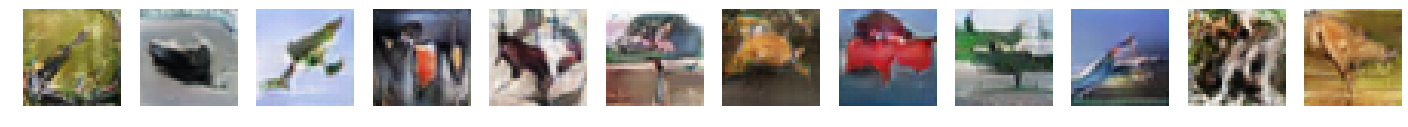

Epoch: 24/55 | Gen. Loss: 3.24024 | Disc. Loss: 0.69980 | Incep. Score: 6.51248
Epoch: 25/55 | Gen. Loss: 3.35787 | Disc. Loss: 0.45310 | Incep. Score: 6.69502


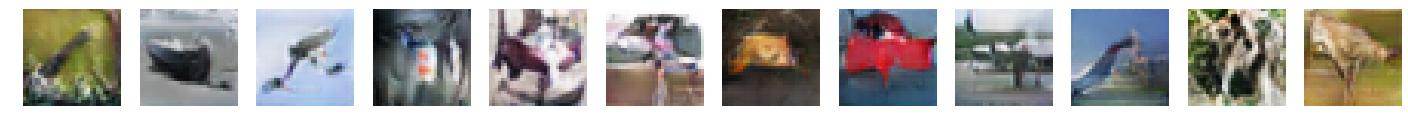

Epoch: 26/55 | Gen. Loss: 3.40351 | Disc. Loss: 0.47137 | Incep. Score: 6.69737


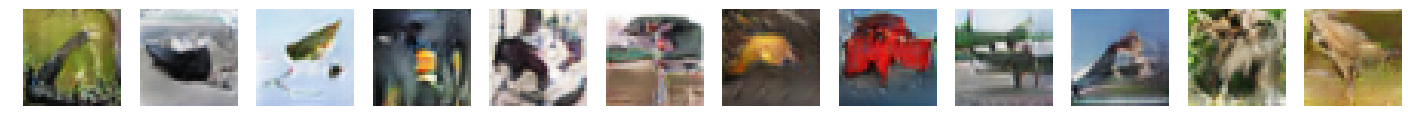

Epoch: 27/55 | Gen. Loss: 3.44771 | Disc. Loss: 0.49250 | Incep. Score: 6.64668
Epoch: 28/55 | Gen. Loss: 3.56433 | Disc. Loss: 0.43179 | Incep. Score: 6.69978


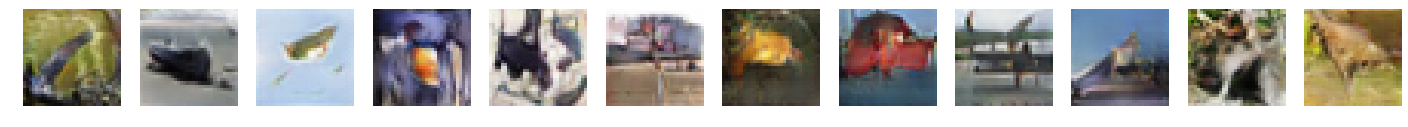

Epoch: 29/55 | Gen. Loss: 3.60524 | Disc. Loss: 0.39758 | Incep. Score: 6.59243
Epoch: 30/55 | Gen. Loss: 3.68967 | Disc. Loss: 0.42623 | Incep. Score: 6.69904
Epoch: 31/55 | Gen. Loss: 3.54460 | Disc. Loss: 0.57765 | Incep. Score: 6.57889
Epoch: 32/55 | Gen. Loss: 3.73519 | Disc. Loss: 0.34651 | Incep. Score: 6.77132


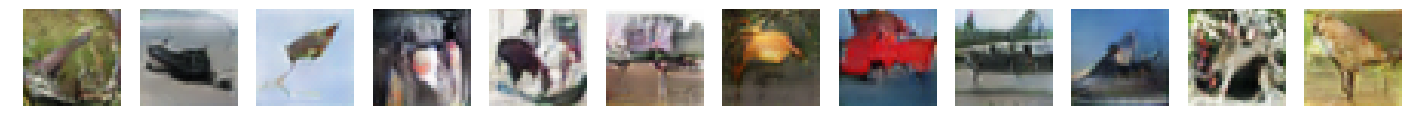

Epoch: 33/55 | Gen. Loss: 3.85461 | Disc. Loss: 0.40875 | Incep. Score: 6.65338
Epoch: 34/55 | Gen. Loss: 3.93175 | Disc. Loss: 0.31791 | Incep. Score: 6.82785


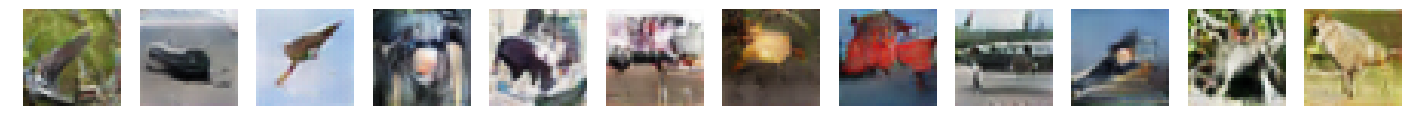

Epoch: 35/55 | Gen. Loss: 3.87597 | Disc. Loss: 0.40929 | Incep. Score: 6.78691
Epoch: 36/55 | Gen. Loss: 3.99106 | Disc. Loss: 0.35477 | Incep. Score: 6.81852
Epoch: 37/55 | Gen. Loss: 3.97083 | Disc. Loss: 0.35433 | Incep. Score: 6.63884
Epoch: 38/55 | Gen. Loss: 4.10962 | Disc. Loss: 0.35536 | Incep. Score: 6.83882


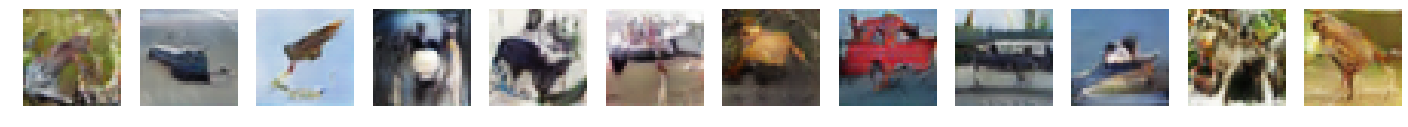

Epoch: 39/55 | Gen. Loss: 4.25333 | Disc. Loss: 0.26656 | Incep. Score: 6.87998


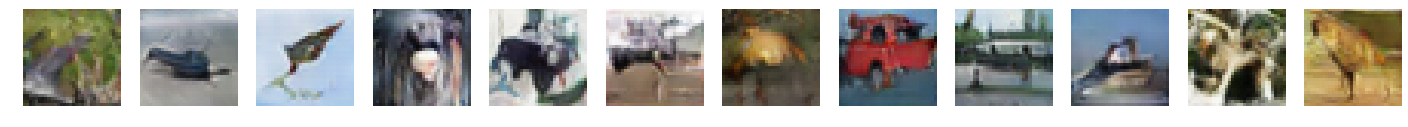

Epoch: 40/55 | Gen. Loss: 4.20724 | Disc. Loss: 0.41969 | Incep. Score: 6.83429
Epoch: 41/55 | Gen. Loss: 4.13630 | Disc. Loss: 0.34306 | Incep. Score: 6.93611


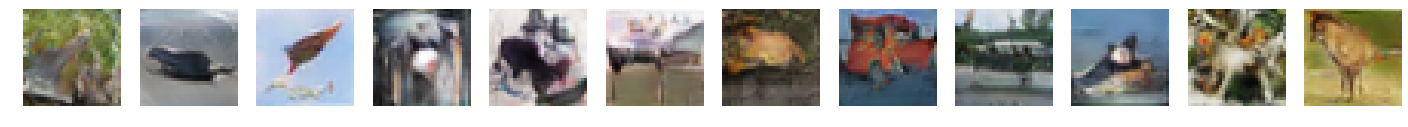

Epoch: 42/55 | Gen. Loss: 4.23975 | Disc. Loss: 0.26668 | Incep. Score: 6.87607
Epoch: 43/55 | Gen. Loss: 4.24684 | Disc. Loss: 0.46059 | Incep. Score: 6.94416


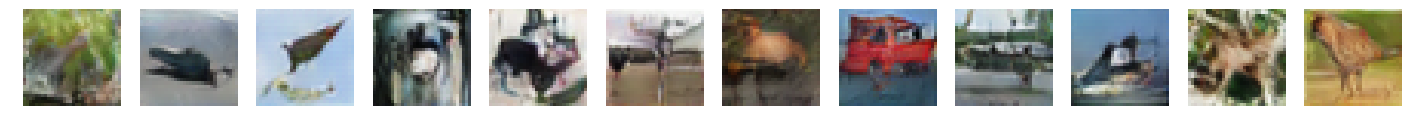

Epoch: 44/55 | Gen. Loss: 4.27714 | Disc. Loss: 0.24775 | Incep. Score: 6.97528


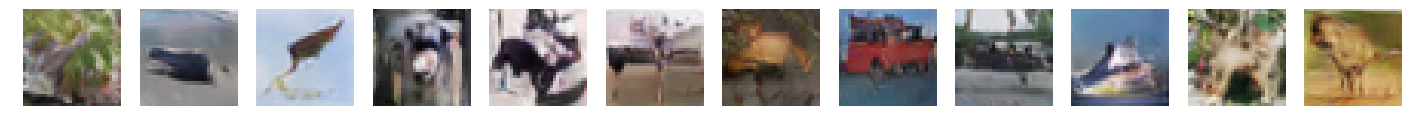

Epoch: 45/55 | Gen. Loss: 4.32098 | Disc. Loss: 0.34491 | Incep. Score: 6.85379
Epoch: 46/55 | Gen. Loss: 4.47082 | Disc. Loss: 0.30220 | Incep. Score: 6.93635
Epoch: 47/55 | Gen. Loss: 4.51334 | Disc. Loss: 0.31183 | Incep. Score: 7.09244


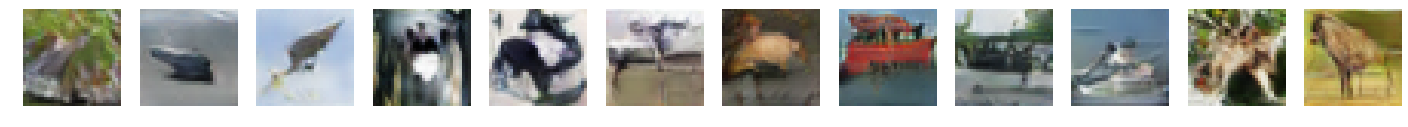

Epoch: 48/55 | Gen. Loss: 4.46939 | Disc. Loss: 0.33595 | Incep. Score: 6.98201
Epoch: 49/55 | Gen. Loss: 4.47483 | Disc. Loss: 0.18587 | Incep. Score: 7.04123
Epoch: 50/55 | Gen. Loss: 4.41245 | Disc. Loss: 0.47282 | Incep. Score: 6.99397
Epoch: 51/55 | Gen. Loss: 4.61265 | Disc. Loss: 0.17489 | Incep. Score: 6.99665
Epoch: 52/55 | Gen. Loss: 4.51555 | Disc. Loss: 0.45752 | Incep. Score: 6.85254
Epoch: 53/55 | Gen. Loss: 4.51063 | Disc. Loss: 0.18997 | Incep. Score: 7.11878


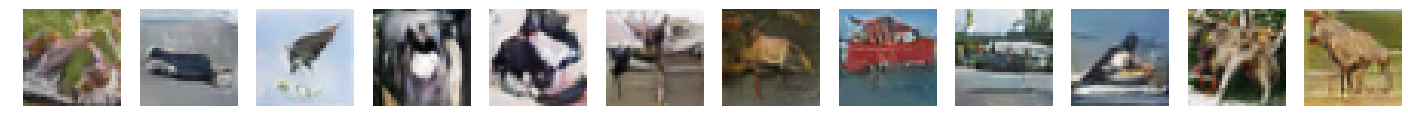

Epoch: 54/55 | Gen. Loss: 4.66848 | Disc. Loss: 0.37026 | Incep. Score: 6.96420
Epoch: 55/55 | Gen. Loss: 4.61397 | Disc. Loss: 0.21925 | Incep. Score: 6.99591


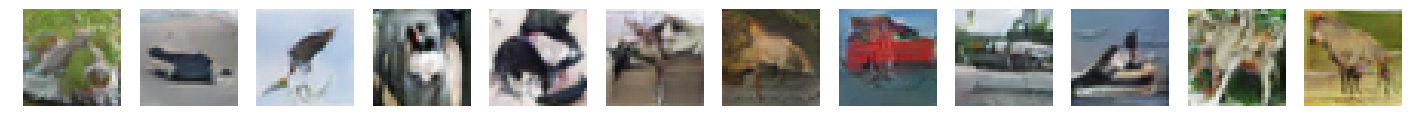

In [0]:
EPOCHS = 55 # 55 * 50000 // 64 ~ 40k iterations
SAMPLES = 12

torch.manual_seed(SEED)
zf = torch.randn(SAMPLES, LATENT_DIM, 1, 1).to(device) # fixed noise for sampling

best_score = 0.0

lossesG = []
lossesD = []
scores = []
for e in range(1, EPOCHS + 1):
    lossesG.append(0)
    lossesD.append(0)
    
    for x, _ in dataloader:
        x = x.to(device)
        z = torch.randn(x.shape[0], LATENT_DIM, 1, 1).to(device)
        Gz = netG(z)
        
        real_labels = torch.ones(x.shape[0], 1).to(device)
        fake_labels = torch.zeros(x.shape[0], 1).to(device)
        
        #----------------Train discriminator: maximize log(D(x)) + log(1 - D(G(z)))----------------#
        real_loss = criterion(netD(x), real_labels) # 0.9 - one-sided label smoothing, to penalize D's overconfidence
        fake_loss = criterion(netD(Gz.detach()), fake_labels) # no need to backprop through G
        
        lossD = (real_loss + fake_loss); lossesD[-1] += lossD.item()
        optD.zero_grad()
        lossD.backward()
        optD.step()

        #-------------------Train generator: maximize log(D(G(z)))-------------------#
        lossG = criterion(netD(Gz), real_labels); lossesG[-1] += lossG.item()
        optG.zero_grad()
        lossG.backward()
        optG.step()

    #-------------------Save losses-------------------#
    lossesG[-1] /= len(dataloader)
    lossesD[-1] /= len(dataloader)
    
    #-------------------Inception score-------------------#
    gen_imgs = []
    for i in range(50):
        z = torch.randn(1000, LATENT_DIM, 1, 1).to(device)
        with torch.no_grad():
            Gz = netG(z)
        imgs = Gz.data.cpu().permute(0, 2, 3, 1).numpy()
        imgs = imgs*127.5 + 127.5 # [-1, 1] --denorm--> [0, 1] --mul by 255--> [0, 255]
        gen_imgs.append(imgs)

    gen_imgs = list(np.concatenate(gen_imgs))
    score = get_inception_score(gen_imgs, batch_size=64, splits=10)
    scores.append(score)
    
    #------------------------Logging------------------------#
    print(f"Epoch: {e:02}/{EPOCHS} "
          f"| Gen. Loss: {lossesG[-1]:.5f} "
          f"| Disc. Loss: {lossesD[-1]:.5f} "
          f"| Incep. Score: {score[0]:.5f}", file=sys.stderr)
    
    if e == EPOCHS or best_score < score[0]:
        best_score = score[0]
        
        #---------------------Saving gen & disc---------------------#
        filepath = f'models/netG-{e:02}-{lossesG[-1]:.3f}-{score[0]:.3f}.pt'
        torch.save(netG.state_dict(), filepath)
        filepath = f'models/netD-{e:02}-{lossesD[-1]:.3f}.pt'
        torch.save(netD.state_dict(), filepath)
        
        #-------------------Sampling the generator-------------------#
        with torch.no_grad():
            Gz = netG(zf)

        fig, ax = plt.subplots(figsize=(22, 20), nrows=1, ncols=SAMPLES)
        for i in range(SAMPLES):
            img = denorm(Gz[i].data.cpu().permute(1, 2, 0))
            ax[i].imshow(img)
            ax[i].axis('off')
        plt.show()

# 3 min (GAN) + 9 min (IS) = 11.8 min/epoch ~ 10.8 hrs

Epoch: 56/65 | Gen. Loss: 4.87231 | Disc. Loss: 0.29553 | Incep. Score: 6.83321
Epoch: 57/65 | Gen. Loss: 4.70281 | Disc. Loss: 0.26553 | Incep. Score: 7.14969


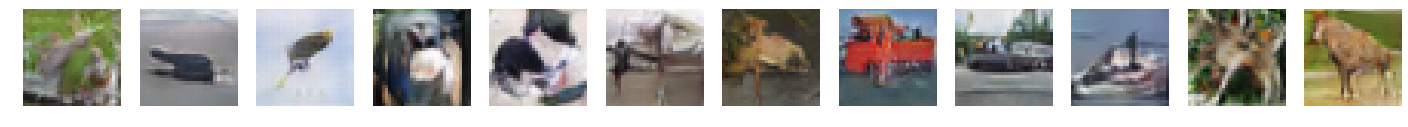

Epoch: 58/65 | Gen. Loss: 4.79411 | Disc. Loss: 0.14270 | Incep. Score: 7.22150


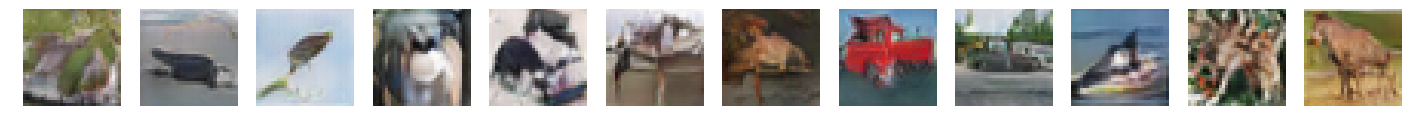

Epoch: 59/65 | Gen. Loss: 4.82772 | Disc. Loss: 0.28569 | Incep. Score: 7.09144
Epoch: 60/65 | Gen. Loss: 4.98519 | Disc. Loss: 0.17086 | Incep. Score: 6.92962
Epoch: 61/65 | Gen. Loss: 4.86132 | Disc. Loss: 0.35811 | Incep. Score: 7.10285
Epoch: 62/65 | Gen. Loss: 4.98827 | Disc. Loss: 0.20452 | Incep. Score: 7.06168
Epoch: 63/65 | Gen. Loss: 4.94121 | Disc. Loss: 0.32980 | Incep. Score: 7.04714
Epoch: 64/65 | Gen. Loss: 5.03064 | Disc. Loss: 0.12381 | Incep. Score: 6.95801
Epoch: 65/65 | Gen. Loss: 5.07000 | Disc. Loss: 0.26944 | Incep. Score: 6.97357


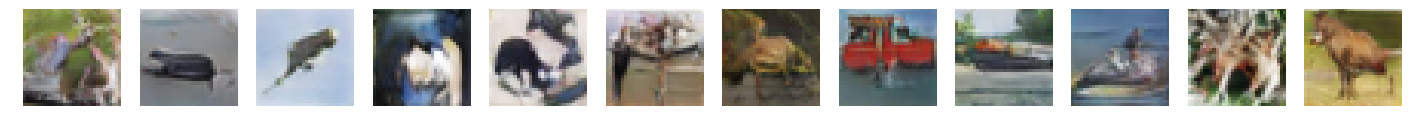

In [0]:
# extending the training to 65 epochs - 65 * 50000 // 64 ~ 50k iterations

In [0]:
lossesG, lossesD, scores = map(np.array, (lossesG, lossesD, scores))
np.savez('models/stats-cifar.npz', lossesG=lossesG, lossesD=lossesD, scores=scores)

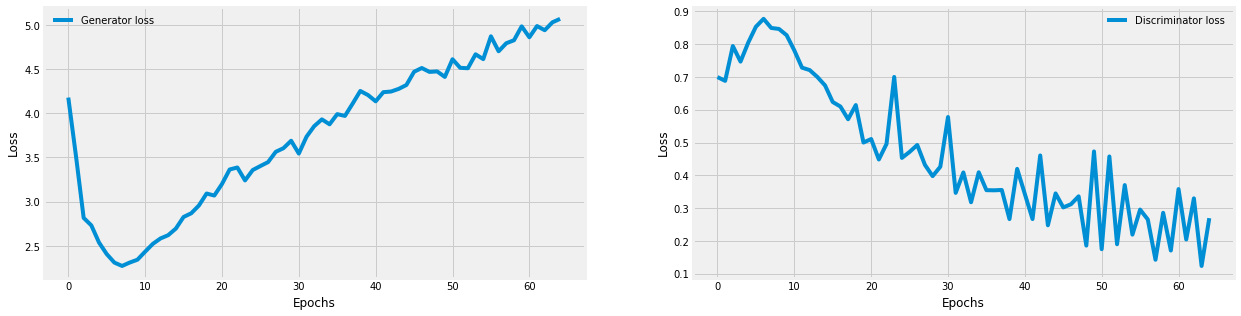

In [0]:
fig = plt.figure(figsize=(19, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(lossesG, label='Generator loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

ax = fig.add_subplot(1, 2, 2)
ax.plot(lossesD, label='Discriminator loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

plt.show()

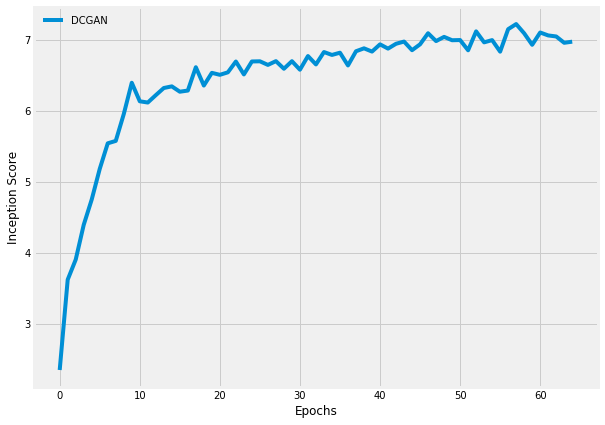

In [0]:
plt.figure(figsize=(9, 7))
plt.plot([mu for mu, std in scores], label='DCGAN') # plot for Guided DCGAN
plt.xlabel('Epochs')
plt.ylabel('Inception Score')
plt.legend(frameon=False)